# Modèle linéaire

# Dépendences

In [176]:
%pip install control

In [177]:
import numpy as np
import matplotlib.pyplot as plt
import control as ct
import pandas as pd
from scipy.io import loadmat

## Speed data

In [204]:
data = loadmat("./Linear/SPEED.mat", squeeze_me=True, struct_as_record=False)

mydata = data['speed']
t = np.array(mydata.time).squeeze()
y = np.array(mydata.signals.values).squeeze()

# Export CSV
df = pd.DataFrame({'Time': t, 'Value': y})
df.to_csv('./Linear/export_scope.csv', index=False)

## Echelon Data

In [205]:
data = loadmat("./Linear/echelon.mat")

y = data['echelon']

df = pd.DataFrame(y)
df.to_csv("./Linear/echelon.csv", index=False)

In [206]:
output = pd.read_csv('/content/Linear/export_scope.csv')
time_step = pd.read_csv('/content/Linear/echelon.csv')
time = output['Time']
value = output["Value"]

In [181]:
Te = 0.01

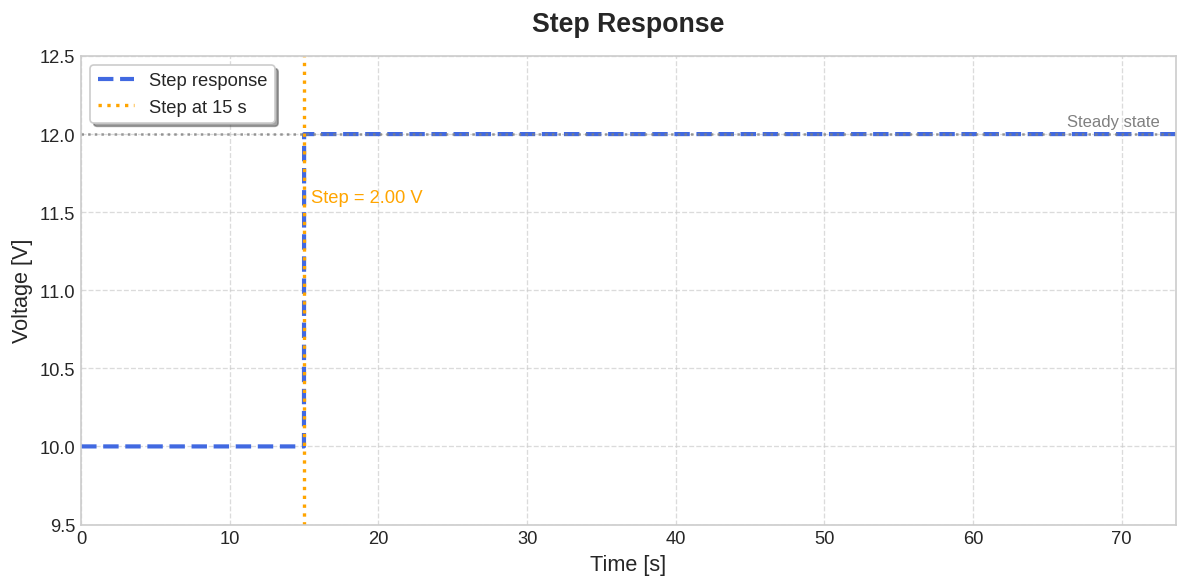

In [182]:
plt.figure(figsize=(10, 5), dpi=120)
plt.style.use('seaborn-v0_8-whitegrid')

# Use the correct time variable from the output DataFrame
time_data = output['Time']

# === Plot step response ===
plt.plot(time_data, time_step.squeeze(), color='royalblue', linestyle='--', linewidth=2.5,
         label='Step response')

# === Beautify axes ===
plt.title("Step Response", fontsize=16, fontweight='bold', pad=15)
plt.xlabel("Time [s]", fontsize=13)
plt.ylabel("Voltage [V]", fontsize=13)

# Add annotation for step time (optional)
step_index = np.argmax(np.diff(time_step.squeeze()))  # index of step change
if step_index > 0:
    step_time = time_data[step_index] # Use time_data
    plt.axvline(step_time, color='orange', linestyle=':', linewidth=2,
                label=f"Step at 15 s")
    plt.text(step_time + 0.5, np.mean(time_step.squeeze()),
             f'Step = {time_step.squeeze()[step_index+1]-time_step.squeeze()[step_index]:.2f} V',
             color='orange', fontsize=11, va='center')

# === Axis limits and ticks ===
plt.xlim([min(time_data), max(time_data)]) # Use time_data
plt.ylim([min(time_step.squeeze()) - 0.5, max(time_step.squeeze()) + 0.5])
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

# === Legend and grid ===
plt.legend(fontsize=11, loc='best', frameon=True, shadow=True)
plt.grid(True, which='major', linestyle='--', alpha=0.7)

# === Optional: add a horizontal steady-state line ===
plt.axhline(max(time_step.squeeze()), color='gray', linestyle=':', linewidth=1.5, alpha=0.8)
plt.text(time_data.iloc[-1]*0.9, max(time_step.squeeze())+0.05, "Steady state", fontsize=10, color='gray') # Use time_data.iloc[-1]

# === Tight layout and show ===
plt.tight_layout()
plt.show()

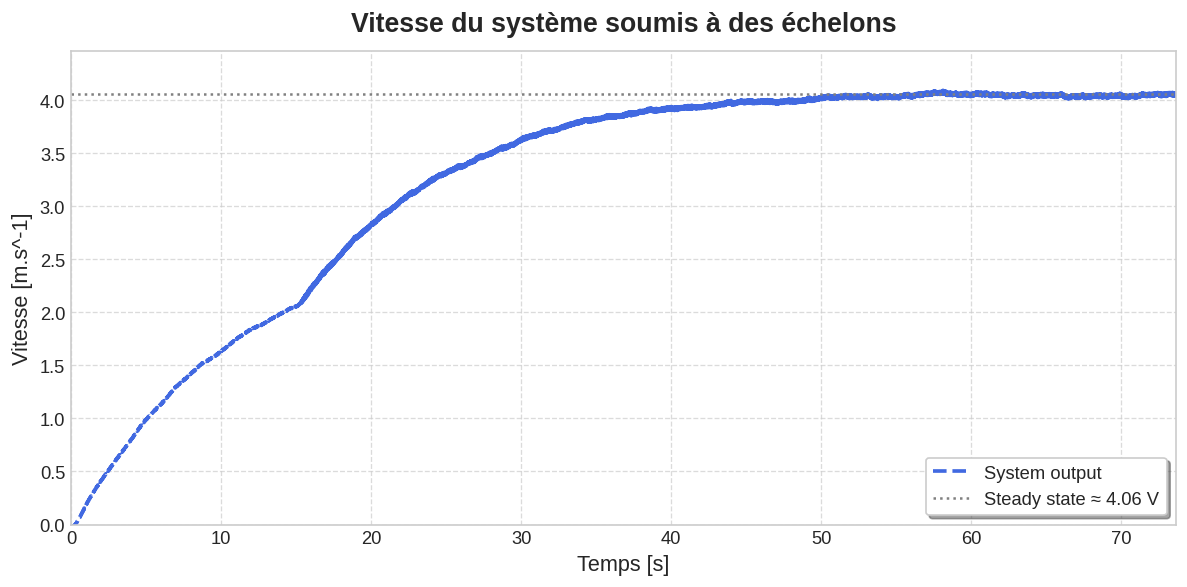

In [207]:
# === Create a figure with nice style ===
plt.figure(figsize=(10, 5), dpi=120)
plt.style.use('seaborn-v0_8-whitegrid')

# Use the correct time and value variables from the output DataFrame
time_data = output['Time']
value_data = output['Value']

# === Plot step response ===
plt.plot(time_data, value_data, color='royalblue', linestyle='--', linewidth=2.2, label='System output')

# === Compute key characteristics (optional) ===
steady_state = np.mean(value_data[-50:])       # average of last points

# === Annotate steady-state and rise time ===
plt.axhline(steady_state, color='gray', linestyle=':', linewidth=1.5, label=f"Steady state ≈ {steady_state:.2f} V")

# === Titles and axis labels ===
plt.title("Vitesse du système soumis à des échelons", fontsize=16, fontweight='bold', pad=12)
plt.xlabel("Temps [s]", fontsize=13)
plt.ylabel("Vitesse [m.s^-1]", fontsize=13)

# === Axes formatting ===
plt.xlim(min(time_data), max(time_data))
plt.ylim(0, steady_state * 1.1)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

# === Legend and grid ===
plt.legend(fontsize=11, loc='best', frameon=True, shadow=True)
plt.grid(True, which='major', linestyle='--', alpha=0.7)

# === Finishing touches ===
plt.tight_layout()
plt.show()

In [184]:
index = int(15/Te)
value_cropped = value[index:]
time_cropped = time[index:]
time_step_cropped = time_step[index:]

In [185]:
time_translated = time_cropped - time_cropped.iloc[0]
value_translated = value_cropped - value_cropped.iloc[0]
time_step_translated = time_step_cropped - time_step_cropped.iloc[0]

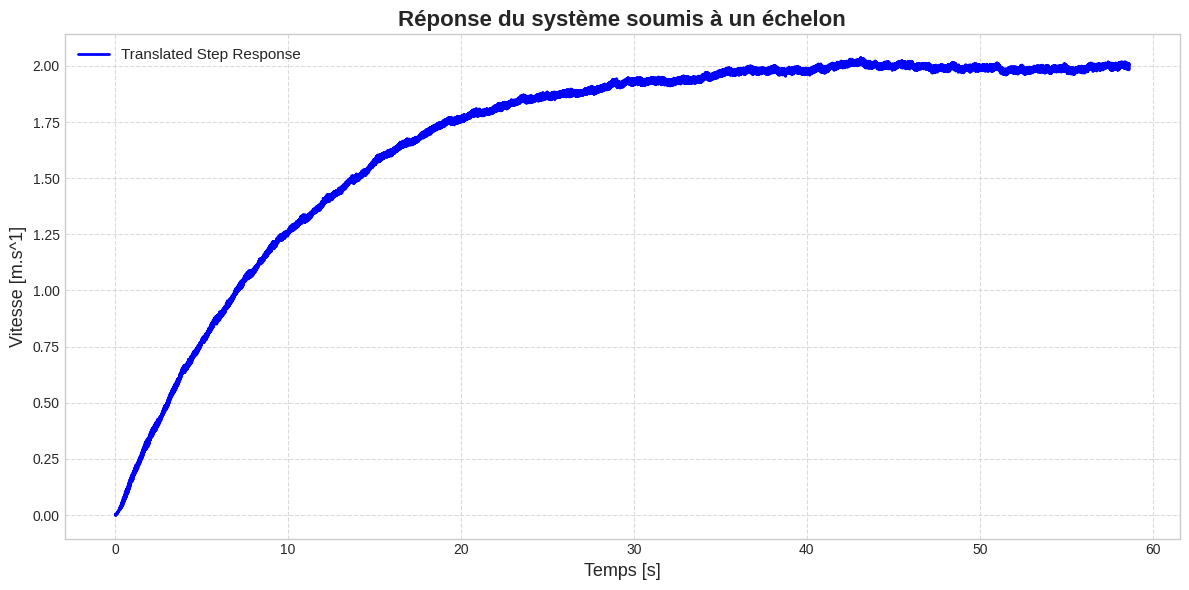

In [213]:
plt.figure(figsize=(12, 6))
plt.style.use('seaborn-v0_8-whitegrid') # Use a nice style
plt.plot(time_translated, value_translated, color='blue', linestyle='-', linewidth=2, label='Translated Step Response') # Changed color and added label
plt.xlabel('Temps [s]', fontsize=13) # Added units and increased font size
plt.ylabel('Vitesse [m.s^1]', fontsize=13) # More descriptive label and increased font size
plt.title('Réponse du système soumis à un échelon', fontsize=16, fontweight='bold') # Added a title
plt.legend(fontsize=11) # Added a legend
plt.grid(True, which='major', linestyle='--', alpha=0.7) # Improved grid
plt.tight_layout() # Adjust layout
plt.show()

In [187]:
X = np.column_stack((value_translated[:-1], np.ones(len(value_translated) - 1)))
y = value_translated[1:]

In [188]:
# Perform the least squares estimation
theta_ls = np.linalg.lstsq(X, y, rcond=None)[0]

In [189]:
theta_ls

array([0.99828086, 0.00321478])

In [190]:
alpha = theta_ls[0]
beta = theta_ls[1]

In [198]:
d = d_opt if 'd_opt' in globals() else 0

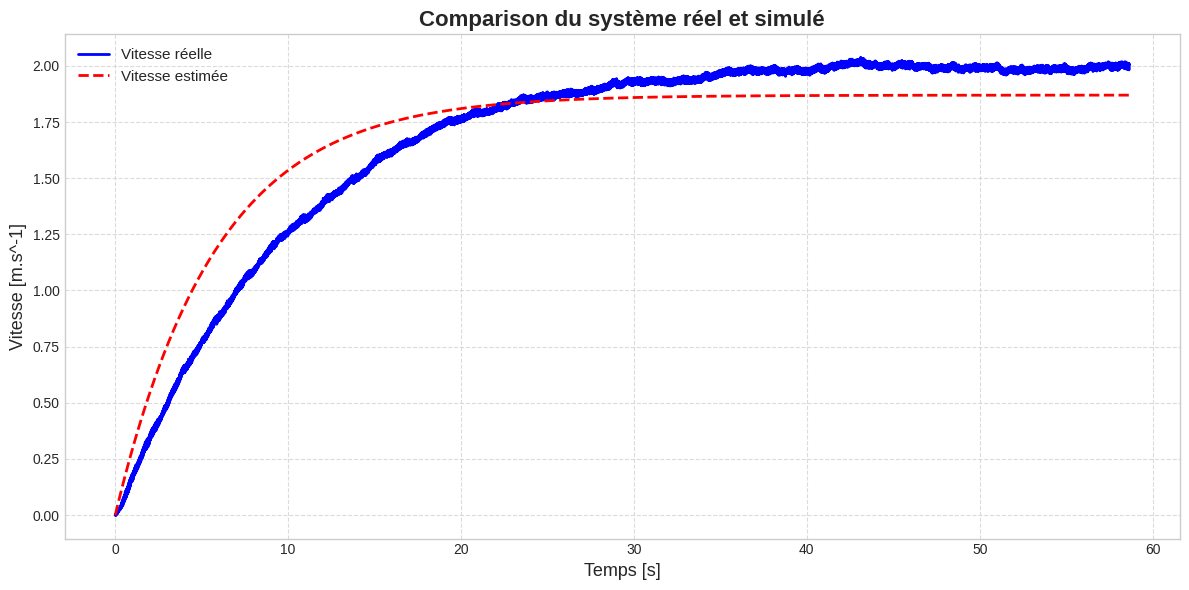

In [214]:
estimated_num = [0]*d + [beta]  # β z^{-1} * z^{-d}
estimated_den = [1, -alpha]     # 1 - α z^{-1}
H_estimated   = ct.tf(estimated_num, estimated_den, Te)

# Use the translated time vector for the model's step response
step_response_estimated = ct.step_response(H_estimated, timepts=time_translated)
output_model = step_response_estimated.outputs

# Plot the translated original data and the estimated model step response
plt.figure(figsize=(12, 6))
plt.style.use('seaborn-v0_8-whitegrid') # Use a nice style
plt.plot(time_translated, value_translated, label='Vitesse réelle', color='blue', linewidth=2) # Added linewidth
plt.plot(time_translated, output_model, label='Vitesse estimée', color='red', linestyle='--', linewidth=2) # Changed linestyle and added linewidth
plt.xlabel('Temps [s]', fontsize=13) # Added units and increased font size
plt.ylabel('Vitesse [m.s^-1]', fontsize=13) # Added units and increased font size
plt.title('Comparison du système réel et simulé', fontsize=16, fontweight='bold') # More descriptive title
plt.legend(fontsize=11) # Added a legend
plt.grid(True, which='major', linestyle='--', alpha=0.7) # Improved grid
plt.tight_layout() # Adjust layout
plt.show()

We are going to try a simpler approach

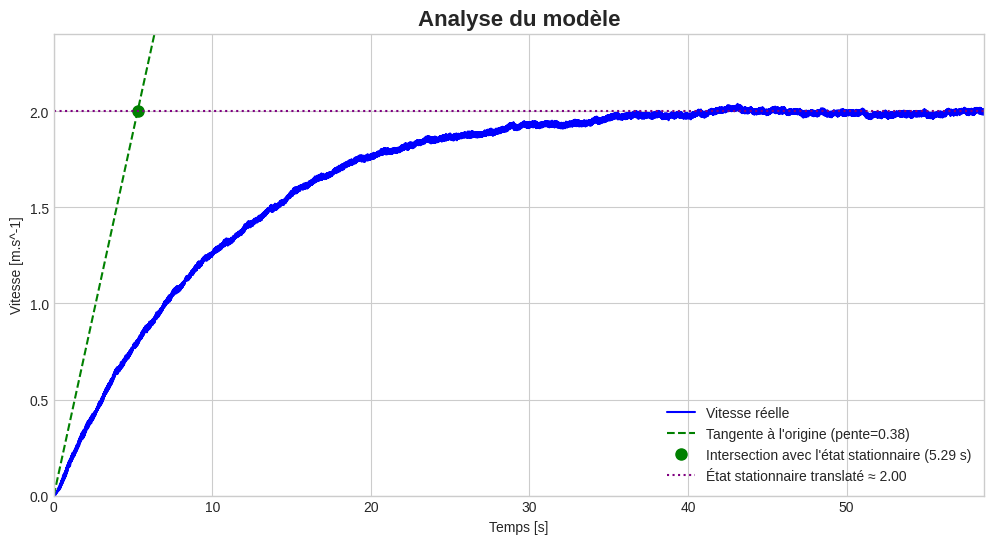

In [217]:
# Calculate the derivative at the origin (first few points)
# Using a simple forward difference
derivative_at_origin = (value_translated.iloc[1] - value_translated.iloc[0]) / (time_translated.iloc[1] - time_translated.iloc[0])

# Calculate the equation of the tangent line at the origin
# y = m*x + c, where m is the derivative and c is the initial value (0 in this case)
tangent_line = derivative_at_origin * time_translated

# Find the intersection with the steady state
# steady_state_value = derivative_at_origin * intersection_time
# intersection_time = steady_state_value / derivative_at_origin

# Calculate the steady state of the translated data
steady_state_translated = np.mean(value_translated[-50:])
intersection_time = steady_state_translated / derivative_at_origin
intersection_point_y = steady_state_translated


# Plot the translated original data and the estimated model step response
plt.figure(figsize=(12, 6))
plt.style.use('seaborn-v0_8-whitegrid') # Use a nice style
plt.plot(time_translated, value_translated, label='Vitesse réelle', color='blue') # Translated label
# plt.plot(time_translated, output_model, label='Réponse du modèle estimé', color='red') # Translated label

# Plot the tangent line at the origin
plt.plot(time_translated, tangent_line, label=f'Tangente à l\'origine (pente={derivative_at_origin:.2f})', color='green', linestyle='--') # Translated label

# Plot the intersection point with the steady state
plt.plot(intersection_time, intersection_point_y, 'go', markersize=8, label=f'Intersection avec l\'état stationnaire ({intersection_time:.2f} s)') # Translated label
plt.axhline(steady_state_translated, color='purple', linestyle=':', linewidth=1.5, label=f"État stationnaire translaté ≈ {steady_state_translated:.2f}") # Translated label


plt.xlabel('Temps [s]') # Translated label and added units
plt.ylabel('Vitesse [m.s^-1]') # Translated label and added units
plt.title('Analyse du modèle', fontsize=16, fontweight='bold') # Translated title
plt.legend() # Added a legend
plt.grid(True)
plt.xlim([0, time_translated.max()]) # Limit x-axis to see the relevant part
plt.ylim([0, steady_state_translated * 1.2]) # Adjust y-axis limit
plt.show()

H = \frac{2}{10s+1}

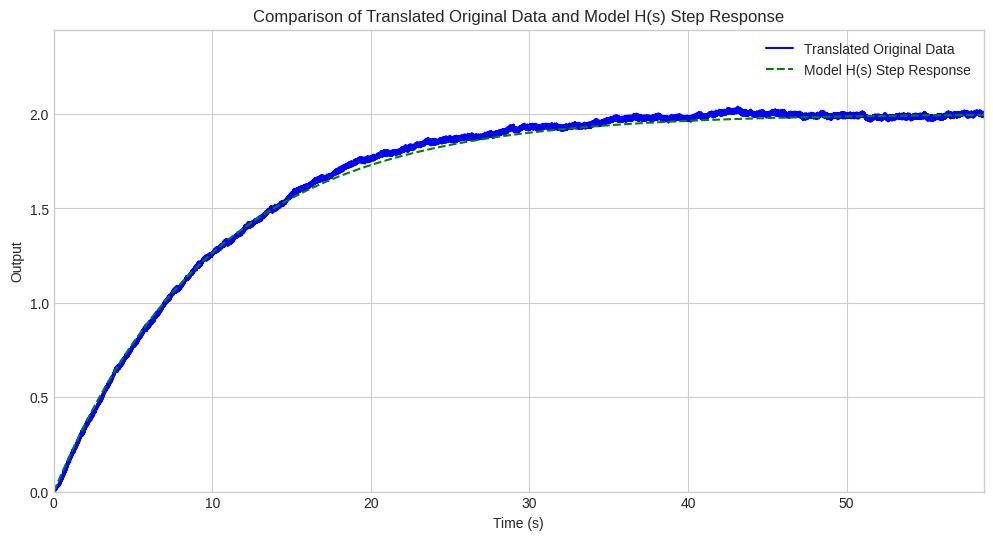

In [194]:
# Define the continuous-time transfer function
num = [2]
den = [10, 1]
H_continuous = ct.tf(num, den)

# Calculate the step response of the continuous-time model
# Use the translated time vector for the simulation
time_for_sim = time_translated.values.flatten() # control requires numpy array
t_sim, y_sim = ct.step_response(H_continuous, T=time_for_sim)


# Plot the translated original data and the estimated model step response
plt.figure(figsize=(12, 6))
plt.plot(time_translated, value_translated, label='Translated Original Data', color='blue')
plt.plot(t_sim, y_sim, label='Model H(s) Step Response', color='green', linestyle='--')


plt.xlabel('Time (s)')
plt.ylabel('Output')
plt.title('Comparison of Translated Original Data and Model H(s) Step Response')
plt.legend()
plt.grid(True)
plt.xlim([0, time_translated.max()])
plt.ylim([0, value_translated.max() * 1.2])
plt.show()